# MobileODT AI researcher interview - Home assignment
In this home assignment, you will take the role of a breast cancer researcher.  Your goal is to train a model to identify pathological evidence of malignancy in Invasive ductal carcinoma (IDC) biopsy slides

To help you focus on the important part and not waste time dealing with I/O and installations, we have created this starter notebook for you to build your code upon.

Please address all questions and assignment sections listed ahead.

Good luck :)

Disclaimer: Although this assignment is designed to test basic skills in Machine learning / deep learning in computer vision domain, it does not use MobileODT's data, address the same expression of pathology nor solve MobileODT's actual classification tasks.

# Colab Setup
Lets setup the google colab notebook to include and utilize GPU capabilities

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
# you dont have to use tensorflow, this block is just intended to validate the existance of a GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data Setup
No need to edit this section. Just run the code blocks to get the dataset ready for your code in the sections ahead

In [ ]:
import os
import zipfile
from shutil import copyfile

Download the data images (to local colab workspace)
please note, this should take 3-4 minutes

In [ ]:
Datapath = '/MODTexcercise/Data/'
if not os.path.exists(Datapath):
  os.makedirs(Datapath)
os.chdir(Datapath)

In [ ]:
# downloadting the image data zip file. Please note the use of the ! command at
# the beginning of the following command. This is an instruction for Colab 
# notebook to run a linux prompt (cmd) command. You are free to run any such 
# prompt commands as you see fit - ususally used for installation of packages 
# not already pre-installed
!wget http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip

--2020-07-30 07:29:30--  http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip
Resolving andrewjanowczyk.com (andrewjanowczyk.com)... 129.22.136.73
Connecting to andrewjanowczyk.com (andrewjanowczyk.com)|129.22.136.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1644892042 (1.5G) [application/zip]
Saving to: ‘IDC_regular_ps50_idx5.zip’

IDC_regular_ps50_id 100%[===================>]   1.53G  13.7MB/s    in 1m 56s  

2020-07-30 07:31:26 (13.5 MB/s) - ‘IDC_regular_ps50_idx5.zip’ saved [1644892042/1644892042]



In [ ]:
ls

unzip images - this should take 2-3min

In [ ]:
Imagespath = os.path.join(Datapath,'Images')
if not os.path.exists(Imagespath):
  os.makedirs(Imagespath)

  ZipPath = os.path.join(Datapath,'IDC_regular_ps50_idx5.zip')
  DataImages_folder = Imagespath

  with zipfile.ZipFile(ZipPath, 'r') as zip_ref:
      zip_ref.extractall(DataImages_folder)

# Classifier training setup

In [ ]:
import pandas as pd
import numpy as np
import os
import glob 
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import cv2

In [ ]:
# defining the dictionary labels for future results display:
dict_characters = {0: 'IDC:Benign(-)', 1: 'IDC:Malignant(+)'}
print(dict_characters)

{0: 'IDC:Benign(-)', 1: 'IDC:Malignant(+)'}


In [ ]:
# reading the images paths and extracting the respective class based on the 
# convention that each image is located in a folder named either 0 (Benign) or 
# 1 (Malignant)

imagePatches = glob.glob(os.path.join(Imagespath, '**/*.png'), recursive=True)
GT_list = [int(os.path.basename(os.path.dirname(x))) for x in imagePatches]


# sanity check:
print(imagePatches[:5])
print(GT_list[:5])

279
['/MODTexcercise/Data/Images/16550/0/16550_idx5_x2401_y1_class0.png', '/MODTexcercise/Data/Images/16550/0/16550_idx5_x2451_y2601_class0.png', '/MODTexcercise/Data/Images/16550/0/16550_idx5_x3551_y601_class0.png', '/MODTexcercise/Data/Images/16550/0/16550_idx5_x901_y1801_class0.png', '/MODTexcercise/Data/Images/16550/0/16550_idx5_x1401_y1101_class0.png']
[0, 0, 0, 0, 0]


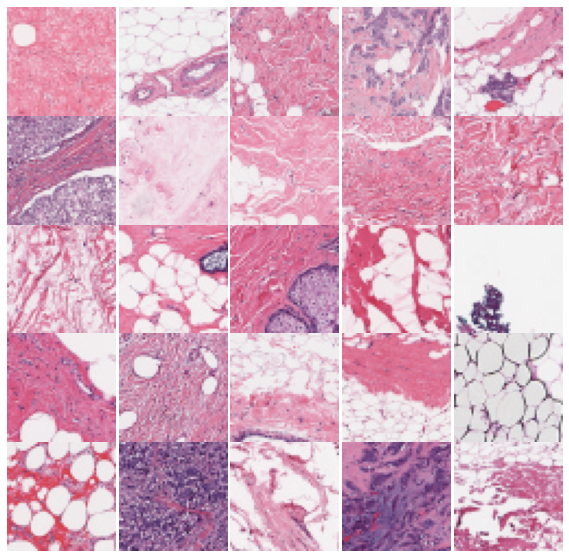

In [ ]:
# Sanity check - making sure the images were downloaded and accessed properly
def display_random_patches(imagePatches):
    random_samples = random.sample(imagePatches, 25)

    i_ = 0
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i_, l in enumerate(random_samples):
        im = cv2.imread(l)
        im = cv2.resize(im, (50, 50))
        plt.subplot(5, 5, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.show()

display_random_patches(imagePatches)

# pre-sampling and resizing images - **Optional**

In [ ]:
# Please note, the use of the following function is NOT REQUIRED 
# 
# This is a helper function in case you don't want to use a predefined / custom 
# built data generator (although it is highly recommended) and would like to 
# pre process your data before beginning to train

def presample_images(imagePatches=[], GT_list=[], sampleNum=None):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    
    data = list(zip(imagePatches, GT_list))
    random.shuffle(data)
    if sampleNum is not None:
        selectedPatches = data[:sampleNum]
    else:
        selectedPatches = data

    for ii, (img, GT) in enumerate(selectedPatches):
        full_size_image = cv2.imread(img)
        xnew = np.expand_dims(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC), axis=0)

        x.append(xnew)
        y.append(GT)
    return x,y

In [ ]:
# Select dataset to work with. Preferrably, use as much data as possible. 
# In this example only 10% of the dataset of 90,000 images, i.e. 9,000 images 
# selected
# 
# As mentioned before, you are encoureged to use predefined/custom data 
# generators, but may use this presampling code if you prefer

# x,y = presample_images(imagePatches=imagePatches, GT_list=GT_list,
#                        sampleNum=9000)

# df = pd.DataFrame({"images":x, "labels":y})

# X = np.vstack(x)
# Y = y

# print('Sanity check: \n', df[:10])

Sanity check: 
                                               images  labels
0  [[[[171 141 174], [188 163 221], [177 143 218]...       0
1  [[[[235 227 240], [241 241 242], [243 244 244]...       0
2  [[[[167 128 167], [171 130 178], [165 119 166]...       1
3  [[[[242 241 242], [241 242 242], [242 242 243]...       0
4  [[[[181 153 219], [213 193 228], [181 155 197]...       0
5  [[[[198 173 213], [210 192 216], [196 174 209]...       1
6  [[[[182 148 171], [222 207 220], [214 197 219]...       0
7  [[[[226 213 233], [230 227 237], [234 233 240]...       0
8  [[[[239 235 241], [233 230 241], [229 218 237]...       0
9  [[[[245 244 244], [244 246 243], [243 243 243]...       0


In [ ]:
# for debug purposes:
def describeData(X,Y, dict_characters):
    print('Total number of images: {}'.format(X.shape[0]))
    for cls, indx in dict_characters.items():
      print('Number of ', cls, ' Images: {}'.format(np.count_nonzero(np.array(Y) == cls)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(Y)))
    print('Image shape (Width, Height, Channels): {}'.format(X.shape[1:]))
describeData(X,Y, dict_characters)

Total number of images: 9000
Number of  0  Images: 6410
Number of  1  Images: 2590
Percentage of positive images: 28.78%
Image shape (Width, Height, Channels): (50, 50, 3)


# Training the Classifier - **Not optional :)**

this is where your task essentially starts.

In this section you will implement a CNN based classifier of your choosing. The only guidelines for this section are:



1.   The data should be split into training, test and validation according to a ratio of 60:20:20 (%).
2.   Ensure all datasamples (X) used are of size 50x50 (Height x Width). If you used the optional pre-sampling code, explain the pro's and con's of such preprocessing
3.   You must incorporate at least 2 augmentations to the images. Explain why they make sense.
4.   The main metric used for performance evaluation (aside from the loss) will be either one of the following (your choice): 


>* accuracy (see https://en.wikipedia.org/wiki/Accuracy_and_precision)
>* ROC-AUC (see https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

5.   The network must converge. No need to let it run for hundreds of epochs, as long as accuracy or ROC-AUC > 70% and shows steady improvement on the validation set, your'e good. 
6.   The test set performace should be roughly similar to the validation set. If the gap is larger than 10% explain why you think is the reason




In [ ]:
# import your choice of libraries here.
# if you need a library that is not installed, run (without the comment of course :)):
# !pip install required_package
import torch
import pandas as pd
import imgaug.augmenters as iaa
import random
from sklearn.metrics import roc_auc_score, roc_curve
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
random.seed(12)
torch.manual_seed(11)
torch.cuda.manual_seed(14)
np.random.seed(15)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [ ]:
pip install imgaug

### **Build dataframe from random 9000 samples:**
##### Build dataframe from image paths and labels, and add folder name to each sample in order to prevent overfit in the continuation.


In [ ]:
def add_folder_name(row):
    splitted_img_path = row['img_path'].split('/')
    row['folder'] = int(splitted_img_path[-3])
    return row
indices = random.sample(range(len(imagePatches)), 9000)

all_folders = [x for x in os.listdir(Imagespath)]
print(len(all_folders))

df = pd.DataFrame({"img_path": np.array(imagePatches)[indices], "labels":np.array(GT_list)[indices]})
df = df.apply(add_folder_name, axis=1)
data_length = len(df)
print(df.head())

                                            img_path  labels  folder
0  /MODTexcercise/Data/Images/12626/0/12626_idx5_...       0   12626
1  /MODTexcercise/Data/Images/9041/0/9041_idx5_x3...       0    9041
2  /MODTexcercise/Data/Images/15471/0/15471_idx5_...       0   15471
3  /MODTexcercise/Data/Images/12242/0/12242_idx5_...       0   12242
4  /MODTexcercise/Data/Images/9250/1/9250_idx5_x1...       1    9250


### **Split data to train-val-test:**

The division is done as following:
We want both split data to 60%-20%-20% (train-val-test) and also prevent from overfit.
I assumed that each folder contains data from the same experiment, so we want that data from spesific folder will not exist in different sets, but only the same set.

In [ ]:
# split dataset to train, val and test in order to prevent overfit

all_folders_cop = all_folders.copy()
train_data = pd.DataFrame(columns=["img_path", "labels", "folder"])

idx = 0
while len(train_data) < int(data_length * 0.6):
    train_data = train_data.append(df.loc[df['folder'] == int(all_folders_cop[idx])])
    idx += 1
all_folders_cop = all_folders_cop[idx:]

val_data = pd.DataFrame(columns=["img_path", "labels", "folder"])
idx = 0
while len(val_data) < int(data_length * 0.2):
    val_data = val_data.append(df.loc[df['folder'] == int(all_folders_cop[idx])])
    idx += 1
all_folders_cop = all_folders_cop[idx:]

test_data = pd.DataFrame(columns=["img_path", "labels", "folder"])
idx = 0
while len(test_data) < int(data_length * 0.2):
    test_data = test_data.append(df.loc[df['folder'] == int(all_folders_cop[idx])])
    if all_folders_cop[idx] == all_folders_cop[-1]:
        break
    idx += 1
all_folders_cop = all_folders_cop[idx:]

if len(all_folders) > 0:
    for folder in all_folders_cop:
        train_data = train_data.append(df.loc[df['folder'] == int(folder)])
        
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
        
print("Total samples in train: {}".format(len(train_data)))
print("Total samples in val: {}".format(len(val_data)))
print("Total samples in test: {}".format(len(test_data)))


Total samples in train: 5423
Total samples in val: 1802
Total samples in test: 1796


### **Build dataset class:**
I used flip left-right and flip up-down as augmentations.
These augmentations are make sense because the carcinoma's texture and shape can be actually with different angles, can be photographed from different views, and each augmentation produce new shape (new shape related to image axes) and angle.

More reasonable augmentations, like blurring and GammaContrast should be added to augmentation list, but I managed to get converge on this dataset without them. <br><br>

**In addition**, to deal with imbalanced data, I decided to change the selection mechanism in the following way - each call to sampler, I randomly (with uniform distribution) pick positive or negative samples from dataset, and from this set I again pick randomly single row. In this way I get balanced data (with uniform distribution). Although apparently negative samples will be selected more than one time per epoch,  the augmentations will make data varied.

In [ ]:
# --- DATASET --- #

class IDCDataset(torch.utils.data.Dataset):
  def __init__(self, relevant_df, mode='train'):
    super(IDCDataset, self).__init__()
    self.data = relevant_df
    self.mode = mode
    self.pos_df = self.data.loc[self.data["labels"] == 1].reset_index(drop=True)
    self.neg_df = self.data.loc[self.data["labels"] == 0].reset_index(drop=True)
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if self.mode != 'test':
      if random.uniform(0, 1) < 0.5:
          ind = int(idx * len(self.neg_df) / len(self.data))
          row = self.neg_df.iloc[ind]
      else:
          ind = int(idx * len(self.pos_df) / len(self.data))
          row = self.pos_df.iloc[ind]
    else:
      row = self.data.iloc[idx]

    image = cv2.imread(row['img_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (50,50), interpolation=cv2.INTER_CUBIC) / 255
    label = row['labels']
    
    if self.mode == 'test':
        tensored_img = torch.from_numpy(image)
        tensored_label = torch.Tensor([label])
        return {'img': tensored_img.permute(2, 1, 0), 'label': tensored_label, 'idx': idx}
    
    else:
        seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.5), 
                              # iaa.GaussianBlur((0, 3.0)),
                              # sometimes(iaa.GammaContrast((0.5, 2.0)))
                              # iaa.OneOf([
                              #       iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                              #       iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                              #       # iaa.MedianBlur(k=(3, 7)), # blur image using local medians with kernel sizes between 2 and 7
                              #           ]), 
                              # sometimes(iaa.OneOf([
                              #       iaa.Add((-10, 10), per_channel=0.5),
                              #       iaa.Multiply((0.9, 1.1), per_channel=0.5)])),
                              # sometimes(iaa.Rotate(-90, 90)),
                              # sometimes(iaa.GammaContrast((0.5, 2.0)))
        ])
        augmented_img = seq(images=image)
        tensored_img = torch.from_numpy(augmented_img)
        tensored_label = torch.Tensor([label])
        return {'img': tensored_img.permute(2, 1, 0), 'label': tensored_label, 'idx': idx}
    
# --- Dataloaders --- #
def get_dataloaders(batch_size):
    train_set = IDCDataset(relevant_df=train_data, mode='train')
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_set = IDCDataset(relevant_df=val_data, mode='val')
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
    test_set = IDCDataset(relevant_df=test_data, mode='test')
    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader


### **Model:**

I built a custom model.
I used blocks concept - sequential of blocks, and each blocks contains 2\3 convolution layers, batch-normalization, Relu and MaxPooling layers.

I used this concept due to successfull expereince I had with it in varied classification tasks.

In [ ]:
# ---- MODEL ---- #
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1_1 = torch.nn.BatchNorm2d(num_features=64)
        self.relu1_1 = torch.nn.ReLU()
        self.conv1_2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1_2 = torch.nn.BatchNorm2d(num_features=64)
        self.relu1_2 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv2_1 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2_1 = torch.nn.BatchNorm2d(num_features=128)
        self.relu2_1 = torch.nn.ReLU()
        self.conv2_2 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2_2 = torch.nn.BatchNorm2d(num_features=128)
        self.relu2_2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv3_1 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3_1 = torch.nn.BatchNorm2d(num_features=256)
        self.relu3_1 = torch.nn.ReLU()
        self.conv3_2 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3_2 = torch.nn.BatchNorm2d(num_features=256)
        self.relu3_2 = torch.nn.ReLU()
        self.conv3_3 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3_3 = torch.nn.BatchNorm2d(num_features=256)
        self.relu3_3 = torch.nn.ReLU()
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv4_1 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4_1 = torch.nn.BatchNorm2d(num_features=512)
        self.relu4_1 = torch.nn.ReLU()
        self.conv4_2 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn4_2 = torch.nn.BatchNorm2d(num_features=512)
        self.relu4_2 = torch.nn.ReLU()
        self.maxpool4 = torch.nn.MaxPool2d(kernel_size=2)
    
        self.conv5_1 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn5_1 = torch.nn.BatchNorm2d(num_features=512)
        self.relu5_1 = torch.nn.ReLU()
        self.conv5_2 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=0)
        self.bn5_2 = torch.nn.BatchNorm2d(num_features=512)
        self.relu5_2 = torch.nn.ReLU()
        
        self.fc1 = torch.nn.Linear(in_features=512, out_features=2)
#         self.fc2 = torch.nn.Linear(in_features=64, out_features=32)
#         self.fc3 = torch.nn.Linear(in_features=32, out_features=2)
    
    def forward(self, X):
        for name, layer in self.__dict__['_modules'].items():
            if name =='fc1':
                batch_size = X.shape[0]
                X = X.view(batch_size, -1)
            X = layer(X)
        return X
    
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


model = Net() 
model.apply(init_weights)

Net(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), str

### **Training:**

In [ ]:
# --- PARAMS --- #
batch_size = 32
lr = 1e-1
wd = 1e-5
epochs = 120
out_folder = './output/running15'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

In [ ]:
def save_model(model, epoch, output_path, best=False):
    if best:
        previous_best_pt = glob.glob(os.path.join(output_path, '*BEST.pt'))
        if len(previous_best_pt) > 0:
            os.remove(previous_best_pt[0])
        name = os.path.join(output_path, 'Model_stateDict__Epoch={}__BEST.pt'.format(epoch))
    else:
        name = os.path.join(output_path, 'Model_stateDict__Epoch={}.pt'.format(epoch))
    torch.save(model.state_dict(),  name)

**loss function** - I used cross-entorpy loss (the common loss for classification tasks). <br>
**Optimizer** - used Adam. <br>
**Scheduler** - I reduce lr by factor of 10 for each 15 epochs without validation loss improvment.


In [ ]:
# --- LOS FUNCTION ---###

weight = torch.Tensor([0.3, 0.7])
ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15)

NameError: ignored

In [ ]:
train_dataset, val_dataset, test_dataset = get_dataloaders(batch_size=batch_size)
print("Pos samples (train)= {} / {}".format(len(train_dataset.dataset.data.loc[train_dataset.dataset.data["labels"] == 1]), len(train_dataset.dataset.data)))
print("Neg samples (train)= {} / {}".format(len(train_dataset.dataset.data.loc[train_dataset.dataset.data["labels"] == 0]), len(train_dataset.dataset.data)))

Pos samples (train)= 1639 / 5423
Neg samples (train)= 3784 / 5423


In [ ]:
# ---- TRAINING ---- #
train_loss_list, val_loss_list, best_train_loss, best_val_loss =[], [], np.inf, np.inf
current_lr, current_wd =[], []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)

best_model = None
for epoch in range(epochs):
    # --- TRAIN:  --- #
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_dataset):
            inputs, labels = data['img'].to(device), data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs.type(torch.FloatTensor).to(device))
            loss = ce_loss(outputs, labels.squeeze().cuda().long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / (i + 1)
        train_loss_list.append(train_loss)
    ##################
        
    # --- VAL:  --- #
        model.eval()
        val_running_loss = 0.0
        for val_i, val_data_ in enumerate(val_dataset):
            inputs, labels = val_data_['img'].to(device), val_data_['label'].to(device)
            outputs = model(inputs.type(torch.FloatTensor).to(device))
            loss = ce_loss(outputs, labels.squeeze().cuda().long())
            val_running_loss += loss.item()
        val_loss = val_running_loss / (val_i + 1)
        val_loss_list.append(val_loss)
    ##################
        
    # --- Save params---#
        current_lr.append(optimizer.param_groups[-1]['lr'])
        current_wd.append(optimizer.param_groups[-1]['weight_decay'])
    # --- Save model checkpoint ---#
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            save_model(model=model, epoch=epoch, output_path=out_folder, best=True)
        elif epoch % 10:
            save_model(model=model, epoch=epoch, output_path=out_folder, best=False)   
    ###############################

        scheduler.step(val_loss)
        print("Epoch {}:  train loss: {:.5f}, val loss: {:.5f}".format(epoch, train_loss, val_loss))

Epoch 0:  train loss: 0.97635, val loss: 0.92177
Epoch 1:  train loss: 0.51269, val loss: 0.60990
Epoch 2:  train loss: 0.49124, val loss: 0.48327
Epoch 3:  train loss: 0.45925, val loss: 0.56195
Epoch 4:  train loss: 0.46876, val loss: 0.54978
Epoch 5:  train loss: 0.46041, val loss: 0.89653
Epoch 6:  train loss: 0.46668, val loss: 1.10397
Epoch 7:  train loss: 0.48681, val loss: 0.52402
Epoch 8:  train loss: 0.45741, val loss: 0.42980
Epoch 9:  train loss: 0.44183, val loss: 0.59127
Epoch 10:  train loss: 0.44378, val loss: 0.64825
Epoch 11:  train loss: 0.44296, val loss: 1.34093
Epoch 12:  train loss: 0.44484, val loss: 1.96542
Epoch 13:  train loss: 0.46301, val loss: 0.64600
Epoch 14:  train loss: 0.43723, val loss: 0.43965
Epoch 15:  train loss: 0.43177, val loss: 0.71951
Epoch 16:  train loss: 0.43935, val loss: 0.49092
Epoch 17:  train loss: 0.42312, val loss: 0.70890
Epoch 18:  train loss: 0.42749, val loss: 0.55957
Epoch 19:  train loss: 0.45496, val loss: 0.62102
Epoch 20: 

In [ ]:
ls

best_model.pt  IDC_regular_ps50_idx5.zip  Images/  output/


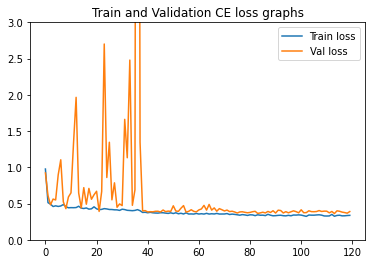

In [ ]:
# summarize this section's efforts:

# present and analyze the model's performance (training, validation and test.
# use any metrics/calculations/visualizations you see fit, in addition to the 
# accuracy/AUC, to describe the performance. if a threshold was selected, 
# explain the choice of threshold value.

# describe the optimization considerations, model and hyperparameter fine tuning 
# process and any thoughs regarding the model structure selected.

# finally, is the model underfitting or overfitting? what can be done to improve
# the bias-variance tradeoff and what could be done to improve the performance in
# general (aside from additional training epochs if too few were run)?

plt.plot(range(epochs), train_loss_list, label='Train loss')
plt.plot(range(epochs), val_loss_list, label='Val loss')
plt.ylim(0, 3)
plt.legend(loc='best')
plt.title('Train and Validation CE loss graphs')
plt.show()

As is shown in the results, I can slightly improve the convergence and avoid from the instability in the training's beginning.
This instability caused due to high lr, and also from the fact I trained network from scratch. This can be solved easily by hyperparameters searching (like Bayssian optimization), but it takes a while...
<br>
<br>
Model is slightly overfit (we can see that train loss is lower than validation loss). In order to improve this, I can increase weight-decay, add Dropout to the network and adding more augmentations. <br>

--------------------------------------------------------------------------


### **Check KPI:**
From training procedure I selected the best model according to min validation loss.<br>
With this model I want to execute sanity check with validation set in order to understand if I indeed got a good convergence and what is the gap, and of course check the model with the test set. <br>
Good convergence and training should produces similar results.

Validation ROC_AUC score = 0.9144182825996694


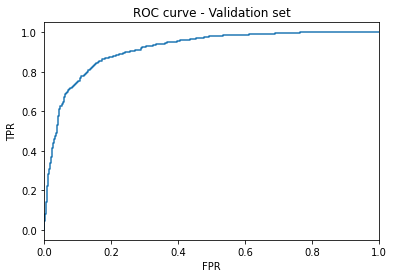

In [ ]:
# --- Sanity check on val set with best model --- #
softmax = torch.nn.Softmax(dim=1)
val_model_output_list, val_label_list = [], []
best_model.eval()
for test_i, val_data_ in enumerate(val_dataset):
            inputs, labels = val_data_['img'].to(device), val_data_['label'].to(device)
            val_label_list.append(labels.squeeze().tolist())
            outputs = best_model(inputs.type(torch.FloatTensor).to(device))
            outputs = softmax(outputs)
            val_model_output_list.append(outputs.squeeze().tolist())
val_flat_labels = [item for sublist in val_label_list for item in sublist]
val_flat_outputs = [item for sublist in val_model_output_list for item in sublist]
val_y_true_, val_y_score_ = np.array(val_flat_labels), np.array(val_flat_outputs)[:, 1]
val_fpr, val_tpr, val_thresholds = roc_curve(y_true=val_y_true_ , y_score=val_y_score_)
print("Validation ROC_AUC score = {}".format(roc_auc_score(y_true=val_y_true_, y_score=val_y_score_)))

plt.plot(val_fpr, val_tpr)
plt.xlabel('FPR')
plt.xlim([0, 1])
plt.ylabel('TPR')
plt.title('ROC curve - Validation set')
plt.show()

Test ROC_AUC score = 0.9047682967948748


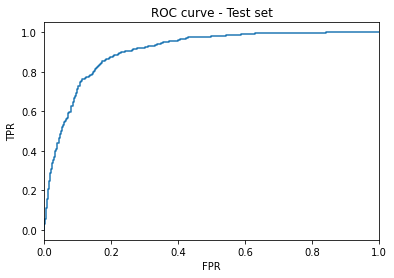

In [ ]:
# --- TEST --- #
model_output_list, label_list = [], []
best_model.eval()
for test_i, test_data_ in enumerate(test_dataset):
            inputs, labels = test_data_['img'].to(device), test_data_['label'].to(device)
            label_list.append(labels.squeeze().tolist())
            outputs = best_model(inputs.type(torch.FloatTensor).to(device))
            outputs = softmax(outputs)
            model_output_list.append(outputs.squeeze().tolist())

flat_labels = [item for sublist in label_list for item in sublist]
flat_outputs = [item for sublist in model_output_list for item in sublist]

y_true_, y_score_ = np.array(flat_labels), np.array(flat_outputs)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=y_true_ , y_score=y_score_)
print("Test ROC_AUC score = {}".format(roc_auc_score(y_true=y_true_, y_score=y_score_)))

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.xlim([0, 1])
plt.ylabel('TPR')
plt.title('ROC curve - Test set')
plt.show()

We got ROC_AUC score of 91% on validation set, and 90% on test set.<br>
The results are similar, which indicates I had nice convergence and good training.<br>
<br>
As we can see from ROC curve, we can choose a threshold that gives us small (around 0.2), but on the other hand will preserve good TPR (around 90%).

# Alternative considerations

In [ ]:
# describe at least two differnt (to classic CNN based) approaches to the 
# presented pathology detection task. There's no need to implement - just explain 
# the approaches and their rational (and provide links to description online if 
# well known methods) and describe the potential pro's and cons of these methods

**(1) K-NN-** From each image sample we will extract 1-dim feature vector (can be done by PCA, autoencoder and also manually features design). With the train set we will use as "references", and each new test sample will compare (with some distance method: L1, L2, correlation, KL-distance, bhattacharyya distance,etc.) to the reference samples. Then we can compute assignment to each class with K-NN: An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. <br>
<br>
**(2) Blobs detection and histogram comparing-** We know what characterized abnormal cell with IDC (type of yellow color instead of purple). We can segment the image with classical segmentation method (edge detection, morphology and then blob segmentation). Then iterate each blob and check the blob's cell colors and textures. <br>


# Training using pre-trained network - **bonus**

Repeat the previous section training task. This time use a pre-trained network of your choice.
explain the considerations behaind selecting the pretrained model and retraining strategy

In [ ]:
# import your choice of libraries here.
# if you need a library that is not installed, run (without the comment of course :)):
# !pip install required_package
import torchvision

I decided to test one of SOTA classification architecture -ResNet50.<br>
For the finetune I replaced the last layer with another linear layer with 2 neurons on the output. <br>
In addition, I froze the training for all layers except last block. This freezing will remain the feature extraction of origin network, and just allow us small training for our task.

In [ ]:
# implement your code here
import torchvision

pretrained_resnet = torchvision.models.resnet50(pretrained=True)
pretrained_resnet.fc = torch.nn.Linear(in_features=2048, out_features=2)
torch.nn.init.xavier_uniform_(pretrained_resnet.fc.weight)
pretrained_resnet.fc.bias.data.fill_(0.01)
# Train just last sequential and fc layer:
for idx, layer in enumerate(pretrained_resnet.children()):
    if idx < 7:
        for param in layer.parameters():
            param.requires_grad = False
        
# --- PARAMS --- #
batch_size = 32
lr = 1e-6
wd = 1e-3
epochs = 120
out_folder = './output/finetune1'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pretrained_resnet.parameters())
, lr=lr, weight_decay=wd)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15)
ce_loss = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
# ---- TRAINING ---- #
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([2.5]).cuda())
train_loss_list_finetune, val_loss_list_finetune, best_train_loss_finetune, \
best_val_loss_finetune =[], [], np.inf, np.inf
current_lr_finetune, current_wd_finetune =[], []

device_finetune = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

pretrained_resnet.to(device_finetune)

best_model_finetune = None
for epoch in range(epochs):
    # --- TRAIN:  --- #
        pretrained_resnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_dataset):
            inputs, labels= data['img'].to(device_finetune), data['label'].to(device_finetune)
            optimizer.zero_grad()
            outputs = pretrained_resnet(inputs.type(torch.FloatTensor).to(device_finetune))
            # loss = criterion(outputs, labels)
            # outputs = torch.sigmoid(outputs)
            loss = ce_loss(outputs, labels.squeeze().cuda().long())
#             loss_class_weighted = loss * weight
#             loss_class_weighted = loss_class_weighted.mean()
#             loss_class_weighted.backward()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / (i + 1)
        train_loss_list_finetune.append(train_loss)
    ##################
        
        pretrained_resnet.eval()
        # --- VAL:  --- #
        val_running_loss = 0.0
        for val_i, val_data_ in enumerate(val_dataset):
            inputs, labels = val_data_['img'].to(device_finetune), val_data_['label'].to(device_finetune)
            outputs = pretrained_resnet(inputs.type(torch.FloatTensor).to(device_finetune))
            # loss = criterion(outputs, labels)
            # outputs = torch.sigmoid(outputs)
            loss = ce_loss(outputs, labels.squeeze().cuda().long())
#             loss_class_weighted = loss * weight
#             loss_class_weighted = loss_class_weighted.mean()
            val_running_loss += loss.item()
        val_loss = val_running_loss / (val_i + 1)
        val_loss_list_finetune.append(val_loss)
        ##################
        
        # --- Save params---#
        current_lr_finetune.append(optimizer.param_groups[-1]['lr'])
        current_wd_finetune.append(optimizer.param_groups[-1]['weight_decay'])
        # --- Save model checkpoint ---#
        if val_loss < best_val_loss_finetune:
            best_val_loss_finetune = val_loss
            best_model_finetune = pretrained_resnet
        #     save_model(model=model, epoch=epoch, output_path=out_folder, best=True)
        # elif epoch % 10:
        #     save_model(model=model, epoch=epoch, output_path=out_folder, best=False)
            
        ###############################

        # scheduler.step(val_loss)
        print("Epoch {}:  train loss: {:.5f}, val loss: {:.5f}".format(epoch, train_loss, val_loss))

Epoch 0:  train loss: 0.70654, val loss: 0.69028
Epoch 1:  train loss: 0.64835, val loss: 0.63827
Epoch 2:  train loss: 0.62609, val loss: 0.64440
Epoch 3:  train loss: 0.60760, val loss: 0.61005
Epoch 4:  train loss: 0.59586, val loss: 0.57986
Epoch 5:  train loss: 0.58538, val loss: 0.58226
Epoch 6:  train loss: 0.57408, val loss: 0.59676
Epoch 7:  train loss: 0.55995, val loss: 0.59270
Epoch 8:  train loss: 0.54271, val loss: 0.58935
Epoch 9:  train loss: 0.56604, val loss: 0.56363
Epoch 10:  train loss: 0.54951, val loss: 0.56497
Epoch 11:  train loss: 0.54060, val loss: 0.55867
Epoch 12:  train loss: 0.55308, val loss: 0.56166
Epoch 13:  train loss: 0.54234, val loss: 0.55074
Epoch 14:  train loss: 0.52627, val loss: 0.55268
Epoch 15:  train loss: 0.54359, val loss: 0.57243
Epoch 16:  train loss: 0.51210, val loss: 0.56859
Epoch 17:  train loss: 0.51461, val loss: 0.55511
Epoch 18:  train loss: 0.52176, val loss: 0.54794
Epoch 19:  train loss: 0.51952, val loss: 0.54621
Epoch 20: 

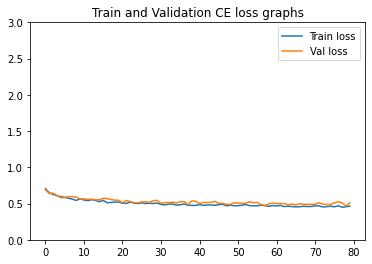

In [ ]:
plt.plot(range(epochs), train_loss_list_finetune, label='Train loss')
plt.plot(range(epochs), val_loss_list_finetune, label='Val loss')
plt.ylim(0, 3)
plt.legend(loc='best')
plt.title('Train and Validation CE loss graphs')
plt.show()

Test ROC_AUC score = 0.7469106505651355


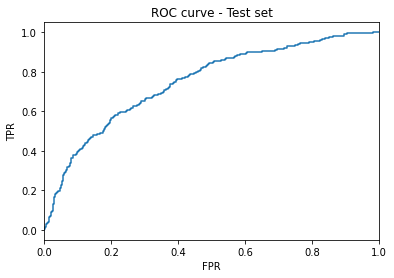

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

softmax = torch.nn.Softmax(dim=1)
model_output_list_finetune, label_list_finetune = [], []
best_model_finetune.eval()
for test_i, test_data_ in enumerate(test_dataset):
            inputs, labels = test_data_['img'].to(device), test_data_['label'].to(device)
            label_list_finetune.append(labels.squeeze().tolist())
            outputs = best_model_finetune(inputs.type(torch.FloatTensor).to(device))
            outputs = softmax(outputs)
            model_output_list_finetune.append(outputs.squeeze().tolist())

flat_labels_finetune = [item for sublist in label_list_finetune for item in sublist]
flat_outputs_finetune = [item for sublist in model_output_list_finetune for item in sublist]

y_true_finetune, y_score_finetune = np.array(flat_labels_finetune), np.array(flat_outputs_finetune)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=y_true_finetune , y_score=y_score_finetune)
print("Test ROC_AUC score = {}".format(roc_auc_score(y_true=y_true_finetune, y_score=y_score_finetune)))

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.xlim([0, 1])
plt.ylabel('TPR')
plt.title('ROC curve - Test set')
plt.show()

In [ ]:
# summarize this section's efforts:

# present and analyze the model's performance (training, validation and test.
# use any metrics/calculations/visualizations you see fit, in addition to the 
# accuracy/AUC, to describe the performance. if a threshold was selected, 
# explain the choice of threshold value.

# describe the optimization considerations and any thoughs regarding the
# model structure selected, the training process and the optimization 
# methods/hyperparameter used.

# finally, is the model underfitting or overfitting? what can be done to improve
# the bias-variance tradeoff and what could be done to improve the performance in
# general?

One mainly different between origin ResNet and our task is the input shape. While the ResNet expects to shape of (224X224) our data is 50X50. Actually, upsampling or padding has done to adjust any shape for fit the pretrained model, while the origin network has trained on data with the above mentioned shape. This difference affects the results and causes degredation in performance relative to my custom network, which was trained from scratch to the small shape. <br>
<br>
**In addition**, again, hyperparameters searching would improve the performance.<br>
<br>
Although, I meet the goal to get ROC_AUC score above 0.7.

# Thank you for your application and time!

When you're done, please send the completed excercise to ronennissim@mobileodt.com for review. 

Good luck!